<a href="https://colab.research.google.com/github/ajaykumar250504/Spotify-Recommendation-System-/blob/main/Spotify_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

In [3]:
data = pd.read_csv('/content/data.csv')
genre_data = pd.read_csv('/content/data_by_genres.csv')
year_data = pd.read_csv('/content/data_by_year.csv')

In [4]:
print(data.info())
print(genre_data.info())
print(year_data.info())
!pip install yellowbrick

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156752 entries, 0 to 156751
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           156752 non-null  float64
 1   year              156752 non-null  int64  
 2   acousticness      156752 non-null  float64
 3   artists           156752 non-null  object 
 4   danceability      156752 non-null  float64
 5   duration_ms       156752 non-null  int64  
 6   energy            156752 non-null  float64
 7   explicit          156752 non-null  int64  
 8   id                156752 non-null  object 
 9   instrumentalness  156752 non-null  float64
 10  key               156752 non-null  int64  
 11  liveness          156752 non-null  float64
 12  loudness          156752 non-null  float64
 13  mode              156752 non-null  int64  
 14  name              156752 non-null  object 
 15  popularity        156751 non-null  float64
 16  release_date      15

In [7]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)
plt.rcParams['figure.figsize']=(20,20)

<Axes: xlabel='count', ylabel='decade'>

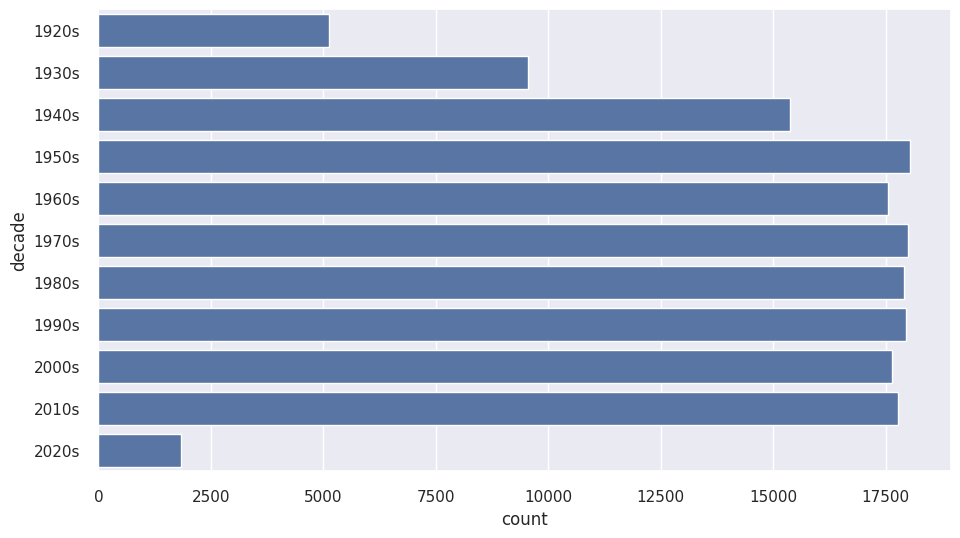

In [8]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(data['decade'])

In [9]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

In [10]:
top10_genres = genre_data.nlargest(10, 'popularity')
fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [12]:
!pip install --upgrade scikit-learn
!pip install threadpoolctl==3.1.0
from sklearn.manifold import TSNE
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.5.0
    Uninstalling threadpoolctl-3.5.0:
      Successfully uninstalled threadpoolctl-3.5.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.006s...
[t-SNE] Computed neighbors for 2973 samples in 0.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.102303
[t-SNE] KL divergence after 1000 iterations: 1.392758


In [16]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 9.2 MB/s eta 0:00:00


In [18]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data

    except IndexError:
        return find_song(song['name'], song['year'])


def get_mean_vector(song_list, spotify_data):

    song_vectors = []

    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):

    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []

    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)

    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')